# 脳活動エンコーダの学習（データを整える）

演習課題については、本ノートブックのほかに、下記3点のファイルが関連している。

- `vim-2_all_data-JA.ipynb`: データセットの概要や解凍方法など（本ノートブックより先に読む）を説明
- `vim-2_encoder_runthrough.ipynb`: ひと通り演習課題の作業を行なった結果を例示
- `vim-2_encoder_practice-JA.pdf`: 演習課題の詳細を記載

本ノートブックでは、データを脳活動エンコーダの学習に使うために整えている。

### 目次
- <a href="#stim_check">元のデータを調べる（視覚刺激）</a>

- <a href="#resp_check">元のデータを調べる（BOLD信号）</a>

- <a href="#h5_start">階層型ファイルを作る</a>

- <a href="#features">視覚的な特徴量を作る</a>

  - 空間的ダウンサンプリング
  - 時間的ダウンサンプリング
  - 畳み込みと特徴量の算出
  - 外れ値の処理
  - 階層型ファイルに追加する


<a id="stim_check"></a>
## 元のデータを調べる（視覚刺激）

それでは、蓋を開けて画像データを見てみよう。

In [1]:
import numpy as np
import tables
import matplotlib
from matplotlib import pyplot as plt
import pprint as pp

自身の環境に合わせて、下記の`_path`を適宜変更しておくこと。

In [2]:
_fmt = ".mat"
_path = "/home/mjh/data_master/vim-2/vim-2/" # Change this!

In [3]:
# Open file connection.
datafile = _path + "Stimuli" + _fmt
f = tables.open_file(datafile, mode="r")
print(f)

/home/mjh/data_master/vim-2/vim-2/Stimuli.mat (File) ''
Last modif.: 'Tue Apr  1 06:58:30 2014'
Object Tree: 
/ (RootGroup) ''
/st (EArray(108000, 3, 128, 128), zlib(3)) ''
/sv (EArray(8100, 3, 128, 128), zlib(3)) ''



データを格納するオブジェクトを指定するとき、階層型データにおけるパスを使うと便利。

In [4]:
# Get object.
node = f.get_node(where="/", name="sv")
print(node)
print(type(node))

/sv (EArray(8100, 3, 128, 128), zlib(3)) ''
<class 'tables.earray.EArray'>


In [5]:
# Close the connection.
f.close()

指定した配列の中身が予想通りのものを格納していること、正しく読み込めていることなどを確かめる必要がある。

In [6]:
# Open file connection.
f = tables.open_file(datafile, mode="r")
node = f.get_node(where="/", name="sv")

今度は配列そのものを読み込む。

In [7]:
# Read array, print out basic attributes.
array = node.read()
print(type(array))
print(array.dtype)

<class 'numpy.ndarray'>
uint8


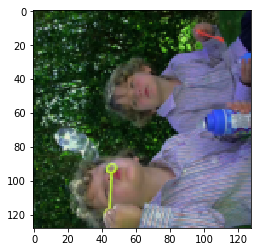

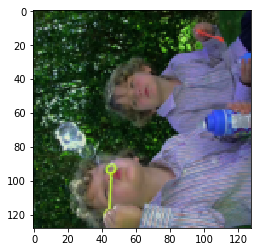

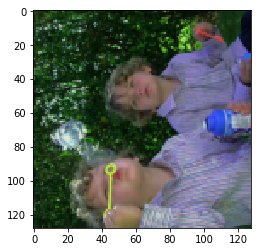

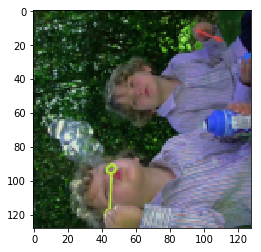

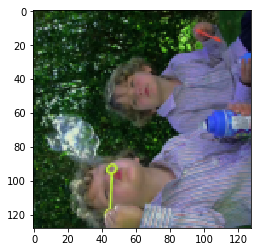

In [8]:
# Print out some frames.
num_frames = array.shape[0]
num_channels = array.shape[1]
frame_w = array.shape[2]
frame_h = array.shape[3]

frames_to_play = 5

new_shape = (frame_h, frame_w, num_channels)
oneframe = np.zeros(num_channels*frame_h*frame_w,
                    dtype=np.uint8).reshape(new_shape)
im = plt.imshow(oneframe)

for t in range(frames_to_play):
    oneframe[:,:,0] = array[t,0,:,:] # red
    oneframe[:,:,1] = array[t,1,:,:] # green
    oneframe[:,:,2] = array[t,2,:,:] # blue
    plt.imshow(oneframe)
    plt.show()

In [9]:
# Close file connection.
f.close()

十分なフレーム数を重ねてみると、読み込んだデータが確かに動画像であることが確認できる。但し、向きがおかしいことと、フレームレートがかなり高いこと、この2点は後ほど対応する。

<a id="resp_check"></a>
## 元のデータを調べる（BOLD信号）


In [1]:
import math
import numpy as np
import tables
import matplotlib
from matplotlib import pyplot as plt
import pprint as pp

_fontsize = "xx-large"

In [2]:
_fmt = ".mat"
_numparts = 3
_path = "/home/mjh/data_master/vim-2/vim-2/VoxelResponses_subject" # Change this!

In [3]:
for i in range(_numparts):
    
    part_id = i+1
    datafile = _path + str(part_id) + _fmt
    f = tables.open_file(datafile, mode="r+") # open in append mode.

    # Delete unnecesary attributes as needed.
    try:
        f.del_node_attr(where="/roi", attrname="MATLAB_fields")
        f.del_node_attr(where="/ei", attrname="MATLAB_fields")
    except AttributeError:
        pass
    
    f.close()

In [4]:
_id = 1
datafile = _path + str(_id) + _fmt

In [5]:
# Open file connection.
f = tables.open_file(datafile, mode="r") # open in read mode.
print(f)

/home/mjh/data_master/vim-2/vim-2/VoxelResponses_subject1.mat (File) ''
Last modif.: 'Fri Jul 26 08:37:08 2019'
Object Tree: 
/ (RootGroup) ''
/rt (EArray(73728, 7200), zlib(3)) ''
/rv (EArray(73728, 540), zlib(3)) ''
/rva (EArray(73728, 10, 540), zlib(3)) ''
/ei (Group) ''
/ei/TRsec (Array(1, 1)) ''
/ei/datasize (Array(3, 1)) ''
/ei/imhz (Array(1, 1)) ''
/ei/valrepnum (Array(1, 1)) ''
/roi (Group) ''
/roi/FFAlh (EArray(18, 64, 64), zlib(3)) ''
/roi/FFArh (EArray(18, 64, 64), zlib(3)) ''
/roi/IPlh (EArray(18, 64, 64), zlib(3)) ''
/roi/IPrh (EArray(18, 64, 64), zlib(3)) ''
/roi/MTlh (EArray(18, 64, 64), zlib(3)) ''
/roi/MTplh (EArray(18, 64, 64), zlib(3)) ''
/roi/MTprh (EArray(18, 64, 64), zlib(3)) ''
/roi/MTrh (EArray(18, 64, 64), zlib(3)) ''
/roi/OBJlh (EArray(18, 64, 64), zlib(3)) ''
/roi/OBJrh (EArray(18, 64, 64), zlib(3)) ''
/roi/PPAlh (EArray(18, 64, 64), zlib(3)) ''
/roi/PPArh (EArray(18, 64, 64), zlib(3)) ''
/roi/RSCrh (EArray(18, 64, 64), zlib(3)) ''
/roi/STSrh (EArray(18, 64, 

In [6]:
_roi = "v4lh"

node_data = f.get_node(where="/", name="rt")
node_idx = f.get_node("/roi", name=_roi)

print("Node for the data:")
print(node_data)
print("Node for the indices:")
print(node_idx)

Node for the data:
/rt (EArray(73728, 7200), zlib(3)) ''
Node for the indices:
/roi/v4lh (EArray(18, 64, 64), zlib(3)) ''


In [7]:
# Get numpy arrays.
data = node_data.read()
idx = node_idx.read().astype(np.int8)

In [8]:
# Close the connection.
f.close()

どういうものを扱っているか、一度俯瞰してみよう。応答の配列の一次元目の長さが73728 = (18 x 64 x 64)である。つまり、一つ一つのボクセルの索引である。この索引（インデックス）を使って、ROIごとにボクセルの集合を抜き取ることが容易にできる。

そのやり方は至って簡単である。まず、インデックス用の配列を眺めてみる。

In [10]:
pp.pprint(idx[0:2, 0:5,0:5])
print("dtype:", idx.dtype)
print("unique:", np.unique(idx))
print("sum =", np.sum(idx))

array([[[0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0]]], dtype=int8)
dtype: int8
unique: [0 1]
sum = 308


ゼロかイチしかないので、18 x 64 x 64の配列のどのセルが「活き」かどうかを示すインディケーターである。上記では、`roi_tocheck`で指定しているROIに含まれるボクセルだけが活き（値が1.0）になっている、という具合である。

In [11]:
with tables.open_file(datafile, mode="r") as f:
    
    node_data = f.get_node(where=f.root, name="rt")
    
    # Extract EArray, the numpy array.
    node_idx = f.get_node(where="/roi", name=_roi)
    
    # Get a flat vector of index values.
    idx = np.nonzero(node_idx.read().flatten())[0]
    
    # Extract a subset; take from the 0th axis the specified indices.
    data = np.take(a=node_data.read(), axis=0, indices=idx)
    print("shape:", data.shape)
    print("dtype:", data.dtype)
    print("type:", type(data))
    print("number of voxels:", idx.size)

shape: (308, 7200)
dtype: float32
type: <class 'numpy.ndarray'>
number of voxels: 308


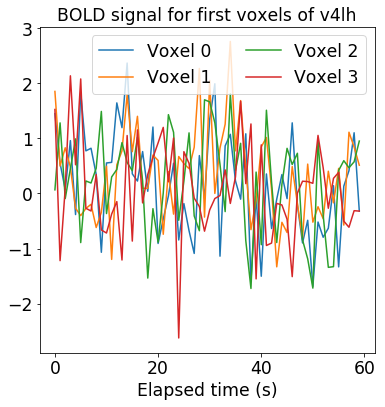

In [12]:
# Visualize the BOLD signal itself for a handful of voxels.
_num_voxels = 4
_time_span = 60

time_idx = np.arange(0, _time_span, 1)

myfig = plt.figure(figsize=(6,6))
ax = myfig.add_subplot(1,1,1)
plt.title(("BOLD signal for first voxels of "+_roi), size=_fontsize)
plt.xlabel("Elapsed time (s)", size=_fontsize)
for v in range(_num_voxels):
    val = data[v,time_idx]
    ax.plot(time_idx, val, label=("Voxel "+str(v)))

ax.tick_params(labelsize=_fontsize)
ax.legend(loc=1,ncol=2, fontsize=_fontsize)

plt.show()

次は欠損値のあるボクセルを取り除く作業を例示する。

In [13]:
# As an illustrative example, let's find the clean indices for one ROI.
with tables.open_file(datafile, mode="r") as f:
    
    node_data = f.get_node(where=f.root, name="rt")
    
    # Extract EArray, the numpy array.
    node_idx = f.get_node(where="/roi", name=_roi)
    
    # Get a flat vector of index values.
    idx = np.nonzero(node_idx.read().flatten())[0]
    
    # Extract a subset; take from the 0th axis the specified indices.
    data = np.take(a=node_data.read(), axis=0, indices=idx)
    
    num_voxels = data.shape[0]
    
    idx_bad_list = []
    idx_clean_list = []
    
    for v in range(num_voxels):
        
        tocheck = np.sum(np.isnan(data[v,:]))

        if (tocheck > 0):
            idx_bad_list += [idx[v]]
        else:
            idx_clean_list += [idx[v]]
    
    print("Number of clean voxels:", len(idx_clean_list))
    print("Number of bad voxels:", len(idx_bad_list))

Number of clean voxels: 308
Number of bad voxels: 0


In [14]:
if len(idx_bad_list) > 0:
    idx_clean = np.array(idx_clean_list)
    data_clean = data[idx_clean,:]
else:
    data_clean = np.copy(data)

print(data_clean.shape)

(308, 7200)


すべてのROIの傾向を見てみよう。

In [15]:
# Iterate over the names, and simply count the non-zero values.
with tables.open_file(datafile, mode="r") as f:
    
    roi_counts = {}
    for roi in f.root.roi._f_iter_nodes():
        countval = np.sum(roi.read(), dtype=np.uint32)
        roi_counts[roi._v_name] = countval

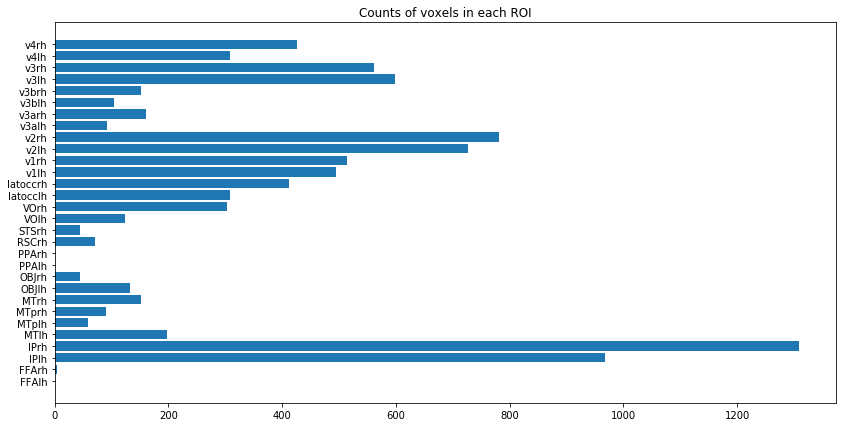

In [16]:
# Plot the counts.
xvals = list(roi_counts.keys())
yvals = list(roi_counts.values())

myfig = plt.figure(figsize=(14,7))
plt.barh(range(len(roi_counts)), yvals)
plt.yticks(range(len(roi_counts)), xvals)
plt.title("Counts of voxels in each ROI")
plt.show()

# For later reference, hold on to this dictionary.
roi_counts_raw = roi_counts

さらに、欠損値のないボクセルに絞る（次のコードブロックの実行には数分かかることも）。

In [17]:
with tables.open_file(datafile, mode="r") as f:
    
    node_data = f.get_node(where=f.root, name="rt")
    
    # Loop over ROIs.
    roi_counts_clean = {}
    for roi in f.root.roi._f_iter_nodes():
        
        # Extract EArray, the numpy array.
        node_idx = f.get_node(where="/roi", name=roi._v_name)
        
        # Get a flat vector of index values.
        idx = np.nonzero(node_idx.read().flatten())[0]
        
        # Extract a subset; take from the 0th axis the specified indices.
        data = np.take(a=node_data.read(), axis=0, indices=idx)
        
        num_voxels = data.shape[0]
        
        idx_bad_list = []
        idx_clean_list = []
        
        for v in range(num_voxels):
            
            tocheck = np.sum(np.isnan(data[v,:]))
            
            if (tocheck > 0):
                idx_bad_list += [idx[v]]
            else:
                idx_clean_list += [idx[v]]
        
        roi_counts_clean[roi._v_name] = len(idx_clean_list)

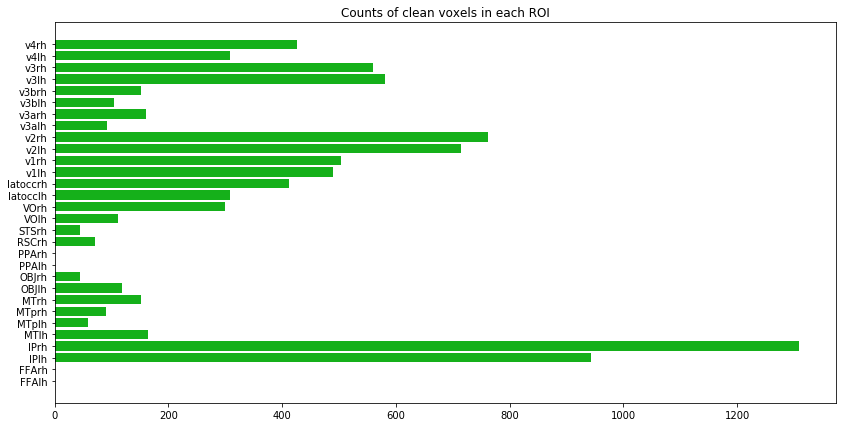

In [18]:
# Plot the counts.
xvals = list(roi_counts_clean.keys())
yvals = list(roi_counts_clean.values())

myfig = plt.figure(figsize=(14,7))
plt.barh(range(len(roi_counts)), yvals, color="xkcd:green")
plt.yticks(range(len(roi_counts)), xvals)
plt.title("Counts of clean voxels in each ROI")
plt.show()

In [19]:
print(roi_counts.values())

dict_values([0, 5, 967, 1308, 197, 58, 91, 152, 132, 44, 0, 0, 71, 45, 124, 304, 309, 413, 494, 514, 726, 781, 92, 160, 104, 152, 598, 562, 308, 426])


In [20]:
print(roi_counts_clean.values())

dict_values([0, 0, 943, 1308, 165, 58, 91, 152, 119, 44, 0, 0, 71, 45, 111, 299, 309, 413, 490, 504, 715, 762, 92, 160, 104, 152, 581, 560, 308, 426])


これでBOLD信号データの状況がある程度見えてきている。ただし、被験者によって傾向が異なることも忘れてはいけない。

<a id="h5_start"></a>
## 階層型ファイルを作る

In [1]:
import numpy as np
import tables
import pickle

In [2]:
_fmt = ".mat"
_numparts = 3
_path = "/home/mjh/data_master/vim-2/vim-2/VoxelResponses_subject" # Change this!

In [3]:
_towrite = "vim-2_encoder_mjh.h5"

In [4]:
# Open file connection, writing new file to disk.
myh5 = tables.open_file(_towrite, mode="w",
                        title="Data for vim-2 based encoder, mjh-style.")
print(myh5)

vim-2_encoder_mjh.h5 (File) 'Data for vim-2 based encoder, mjh-style.'
Last modif.: 'Fri Jul 26 09:44:04 2019'
Object Tree: 
/ (RootGroup) 'Data for vim-2 based encoder, mjh-style.'



In [5]:
_roi_todo = ["v1lh", "v1rh",
             "v2lh", "v2rh"]

In [6]:
# Create all our groups.
for m in range(_numparts):
    myname = "sub" + str(m+1)
    mytitle = "Data for subject " + str(m+1)
    
    myh5.create_group(myh5.root, myname, mytitle)
    myh5.create_group("/"+myname, "tr", "Training data")
    myh5.create_group("/"+myname, "te", "Testing data")

print(myh5)

vim-2_encoder_mjh.h5 (File) 'Data for vim-2 based encoder, mjh-style.'
Last modif.: 'Fri Jul 26 09:44:04 2019'
Object Tree: 
/ (RootGroup) 'Data for vim-2 based encoder, mjh-style.'
/sub1 (Group) 'Data for subject 1'
/sub2 (Group) 'Data for subject 2'
/sub3 (Group) 'Data for subject 3'
/sub3/te (Group) 'Testing data'
/sub3/tr (Group) 'Training data'
/sub2/te (Group) 'Testing data'
/sub2/tr (Group) 'Training data'
/sub1/te (Group) 'Testing data'
/sub1/tr (Group) 'Training data'



In [7]:
# For each participant, open connection with data h5 file,
# get desired data, add array to our new h5 file.

for m in range(_numparts):
    
    datafile = _path + str(m+1) + _fmt
    
    myname = "sub" + str(m+1)
    mytitle = "Data for subject " + str(m+1)
    
    print("Starting on {}.".format(myname))
    
    idx_clean_list_tr = []
    idx_clean_list_te = []
    
    with tables.open_file(datafile, mode="r") as f:
        
        # Loop over ROIs, and get all the clean voxel indices.
        node_data_tr = f.get_node(where=f.root, name="rt")
        node_data_te = f.get_node(where=f.root, name="rv")
        
        for roi in _roi_todo:
            
            print("Doing ROI {}".format(roi))

            # Extract EArray, the numpy array.
            node_idx = f.get_node(where="/roi", name=roi)
            
            # Get a flat vector of index values.
            idx = np.nonzero(node_idx.read().flatten())[0]
            
            # Extract a subset; take from the 0th axis the specified indices.
            data_tr = np.take(a=node_data_tr.read(), axis=0, indices=idx)
            data_te = np.take(a=node_data_te.read(), axis=0, indices=idx)
            
            for v in range(data_tr.shape[0]):
                tocheck_tr = np.sum(np.isnan(data_tr[v,:]))
                tocheck_te = np.sum(np.isnan(data_te[v,:]))
                if (tocheck_tr == 0):
                    idx_clean_list_tr += [idx[v]]
                if (tocheck_te == 0):
                    idx_clean_list_te += [idx[v]]
    
    # Must take intersection of the lists in order to ensure we have
    # voxels that are clean for both training and testing.
    idx_clean_list = []
    for val in idx_clean_list_tr:
        if val in idx_clean_list_te:
            idx_clean_list += [val]
        else:
            pass
    
    idx_clean = np.unique(np.array(idx_clean_list))
    
    print("Final stage: reading and filling arrays")
    with tables.open_file(datafile, mode="r") as f:
        
        node_data_tr = f.get_node(where=f.root, name="rt")
        node_data_te = f.get_node(where=f.root, name="rv")
        
        y_tr = node_data_tr.read()[idx_clean,:]
        y_te = node_data_te.read()[idx_clean,:]

        # Fill in arrays of responses.
        myh5.create_array("/"+myname+"/"+"tr", name="y", obj=y_tr)
        myh5.create_array("/"+myname+"/"+"te", name="y", obj=y_te)
        
        
        # Finally, record the indices from each ROI.
        
        idx_clean_ref = {}
        
        for roi in _roi_todo:
            
            node_idx = f.get_node(where="/roi", name=roi)
            idx = np.nonzero(node_idx.read().flatten())[0]
            
            idx_clean_byroi = []
            
            for i in range(idx_clean.size):
                
                v_tocheck = idx_clean[i]
                
                if v_tocheck in idx:
                    idx_clean_byroi += [i]
                    
            idx_clean_ref[roi] = idx_clean_byroi
            
        fname = "idx_clean_"+"sub"+str(m+1)+".ref"
        with open(fname, mode="bw") as fbin:
            pickle.dump(idx_clean_ref, fbin)

print(myh5)

Starting on sub1.
Doing ROI v1lh
Doing ROI v1rh
Doing ROI v2lh
Doing ROI v2rh
Final stage: reading and filling arrays
Starting on sub2.
Doing ROI v1lh
Doing ROI v1rh
Doing ROI v2lh
Doing ROI v2rh
Final stage: reading and filling arrays
Starting on sub3.
Doing ROI v1lh
Doing ROI v1rh
Doing ROI v2lh
Doing ROI v2rh
Final stage: reading and filling arrays
vim-2_encoder_mjh.h5 (File) 'Data for vim-2 based encoder, mjh-style.'
Last modif.: 'Fri Jul 26 09:46:16 2019'
Object Tree: 
/ (RootGroup) 'Data for vim-2 based encoder, mjh-style.'
/sub1 (Group) 'Data for subject 1'
/sub2 (Group) 'Data for subject 2'
/sub3 (Group) 'Data for subject 3'
/sub3/te (Group) 'Testing data'
/sub3/te/y (Array(2743, 540)) ''
/sub3/tr (Group) 'Training data'
/sub3/tr/y (Array(2743, 7200)) ''
/sub2/te (Group) 'Testing data'
/sub2/te/y (Array(2702, 540)) ''
/sub2/tr (Group) 'Training data'
/sub2/tr/y (Array(2702, 7200)) ''
/sub1/te (Group) 'Testing data'
/sub1/te/y (Array(2471, 540)) ''
/sub1/tr (Group) 'Training dat

In [8]:
# Finally, close file connection.
myh5.close()

<a id="features"></a>
## 視覚的な特徴量を算出

### 空間的ダウンサンプリング

画素数が多すぎると、後の計算が大変になるので、空間的なダウンサンプリング、つまり画像を縮小することが多い。色々なやり方はあるが、ここでは__scikit-image__というライブラリの`transform`モジュールから、`resize`という関数を使う。まずは動作確認。

In [1]:
from skimage import transform
from matplotlib import pyplot as plt
import imageio
import tables
import numpy as np

import gabor

im = imageio.imread("img/bishop.png") # a 128px x 128px image

In [2]:
med_h = 96 # desired height in pixels
med_w = 96 # desired width in pixels
im_med = transform.resize(image=im, output_shape=(med_h,med_w), mode="reflect")

small_h = 32
small_w = 32
im_small = transform.resize(image=im, output_shape=(small_h,small_w), mode="reflect")

tiny_h = 16
tiny_w = 16
im_tiny = transform.resize(image=im, output_shape=(tiny_h,tiny_w), mode="reflect")

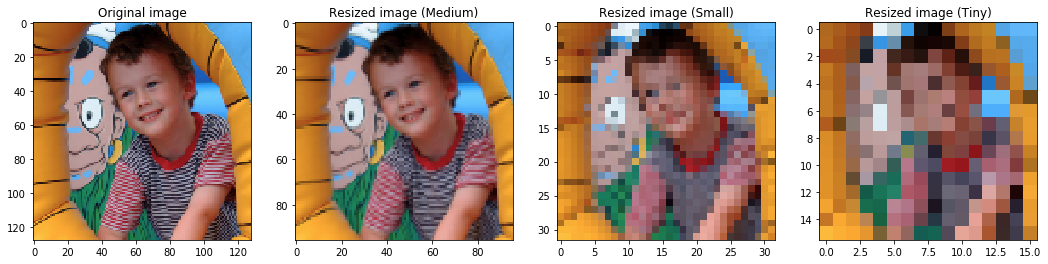

In [3]:
myfig = plt.figure(figsize=(18,4))

ax_im = myfig.add_subplot(1,4,1)
plt.imshow(im)
plt.title("Original image")
ax_med = myfig.add_subplot(1,4,2)
plt.imshow(im_med)
plt.title("Resized image (Medium)")
ax_small = myfig.add_subplot(1,4,3)
plt.imshow(im_small)
plt.title("Resized image (Small)")
ax_small = myfig.add_subplot(1,4,4)
plt.imshow(im_tiny)
plt.title("Resized image (Tiny)")

plt.show()

予想するように動いているようなので、視覚刺激の全フレームに対して同様な操作を行う。

In [4]:
_fmt = ".mat"
_path = "/home/mjh/data_master/vim-2/vim-2/" # Change this!
datafile = _path + "Stimuli" + _fmt
f = tables.open_file(datafile, mode="r")
print(f)

/home/mjh/data_master/vim-2/vim-2/Stimuli.mat (File) ''
Last modif.: 'Tue Apr  1 06:58:30 2014'
Object Tree: 
/ (RootGroup) ''
/st (EArray(108000, 3, 128, 128), zlib(3)) ''
/sv (EArray(8100, 3, 128, 128), zlib(3)) ''



In [5]:
# Open file connection.
f = tables.open_file(datafile, mode="r")

In [6]:
# Get node object and array.
node_tr = f.get_node(where="/", name="st")
node_te = f.get_node(where="/", name="sv")
array_tr = node_tr.read() # takes time
array_te = node_te.read()

In [7]:
# Get basic properties.
num_frames_tr, num_channels_tr = array_tr.shape[0:2]
num_frames_te, num_channels_te = array_te.shape[0:2]

In [8]:
# Swap the axes.
print("Stimulus arrays (before):", array_tr.shape, array_te.shape)
array_tr = np.swapaxes(a=array_tr, axis1=0, axis2=3)
array_tr = np.swapaxes(a=array_tr, axis1=1, axis2=2)
array_te = np.swapaxes(a=array_te, axis1=0, axis2=3)
array_te = np.swapaxes(a=array_te, axis1=1, axis2=2)
print("Stimulus arrays (after):", array_tr.shape, array_te.shape)

Stimulus arrays (before): (108000, 3, 128, 128) (8100, 3, 128, 128)
Stimulus arrays (after): (128, 128, 3, 108000) (128, 128, 3, 8100)


In [9]:
# Prepare new array of downsampled stimulus.
_h = 64
_w = 64

new_array_tr = np.zeros(num_frames_tr*num_channels_tr*_h*_w, dtype=np.float32)
new_array_tr = new_array_tr.reshape((_h, _w, num_channels_tr, num_frames_tr))
new_array_te = np.zeros(num_frames_te*num_channels_te*_h*_w, dtype=np.float32)
new_array_te = new_array_te.reshape((_h, _w, num_channels_te, num_frames_te))

In [10]:
# Iterate over frames to be resized.
print("Training data")
for t in range(num_frames_tr):
    new_array_tr[:,:,:,t] = transform.resize(image=array_tr[:,:,:,t],
                                             output_shape=(_h,_w),
                                             mode="reflect")
    if t % 10000 == 0:
        print("Update: t =", t)

print("Testing data")
for t in range(num_frames_te):
    new_array_te[:,:,:,t] = transform.resize(image=array_te[:,:,:,t],
                                             output_shape=(_h,_w),
                                             mode="reflect")
    if t % 1000 == 0:
        print("Update: t =", t)
        
f.close()

Training data
Update: t = 0
Update: t = 10000
Update: t = 20000
Update: t = 30000
Update: t = 40000
Update: t = 50000
Update: t = 60000
Update: t = 70000
Update: t = 80000
Update: t = 90000
Update: t = 100000
Testing data
Update: t = 0
Update: t = 1000
Update: t = 2000
Update: t = 3000
Update: t = 4000
Update: t = 5000
Update: t = 6000
Update: t = 7000
Update: t = 8000


ここで一つ注意すべきことは、縮小したあとの画像は、$\{0,1,\ldots,255\}$ではなく、$[0,1]$の実数値を取るということである。そのため、`dtype`が`np.float32`に変わっている。

In [11]:
print("(Pre-downsize) maxes:", np.max(array_tr),
      "mins:", np.min(array_tr),
      "aves:", np.mean(array_tr))
print("(Post-downsize) maxes:", np.max(new_array_tr),
      "mins:", np.min(new_array_tr),
      "aves:", np.mean(new_array_tr))

del array_tr, array_te

(Pre-downsize) maxes: 255 mins: 0 aves: 84.74762529330783
(Post-downsize) maxes: 1.0 mins: 0.0 aves: 0.3323463


### 時間的ダウンサンプリング

作業を加速化させるために、ダウンサンプリングを畳み込みの前に行うのだが、逆の順番で行うことも多い。

In [12]:
# Temporal down-sampling.
_framerate = 15
n_tr = new_array_tr.shape[3]//_framerate
n_te = new_array_te.shape[3]//_framerate
print(n_tr)
print(n_te)

7200
540


In [13]:
# Temporal down-sampling.
_framerate = 15
n_tr = new_array_tr.shape[3]//_framerate
n_te = new_array_te.shape[3]//_framerate

## Training data.
tmp_shape = new_array_tr.shape[0:3] + (n_tr,)
tmp_array = np.zeros(tmp_shape, dtype=new_array_tr.dtype)
idx = np.arange(_framerate)
for i in range(n_tr):
    tmp_array[:,:,:,i] = np.mean(new_array_tr[:,:,:,idx], axis=3)
    idx += _framerate
new_array_tr = np.copy(tmp_array)

## Testing data.
tmp_shape = new_array_te.shape[0:3] + (n_te,)
tmp_array = np.zeros(tmp_shape, dtype=new_array_te.dtype)
idx = np.arange(_framerate)
for i in range(n_te):
    tmp_array[:,:,:,i] = np.mean(new_array_te[:,:,:,idx], axis=3)
    idx += _framerate
new_array_te = np.copy(tmp_array)

print("Shapes after down-sampling:", new_array_tr.shape, new_array_te.shape)

Shapes after down-sampling: (64, 64, 3, 7200) (64, 64, 3, 540)


### 畳み込みと特徴量の算出

In [14]:
# Set up the parameters that specify the first filter bank.
_max_cycles = 32 # the maximum cycles per image.
myparas = {"freqs": _max_cycles/max(_w,_h),
           "dir": 0,
           "amp": 0.1,
           "sdev": max(_w,_h)/20,
           "phase": 0}
_grid_h = 4
_grid_w = 4

In [15]:
# Construct features using the specified filter bank.

## Training data (takes some time).
X_tr = gabor.G2_getfeatures(ims=new_array_tr,
                            fil_paras=myparas,
                            gridshape=(_grid_h, _grid_w),
                            mode="reflect", cval=0)

## Testing data (takes some time).
X_te = gabor.G2_getfeatures(ims=new_array_te,
                            fil_paras=myparas,
                            gridshape=(_grid_h, _grid_w),
                            mode="reflect", cval=0)

print("Shapes of X_tr and X_te:", X_tr.shape, X_te.shape)

Shapes of X_tr and X_te: (7200, 16) (540, 16)


### 外れ値の処理

In [16]:
# Z-scoring.
Z_tr = X_tr - np.mean(X_tr, axis=0)
Z_tr = Z_tr / np.std(Z_tr, axis=0)
#print("Mean =", np.mean(Z_tr, axis=0), "StdDev =", np.std(Z_tr, axis=0))
Z_te = X_te - np.mean(X_te, axis=0)
Z_te = Z_te / np.std(Z_te, axis=0)
#print("Mean =", np.mean(Z_te, axis=0), "StdDev =", np.std(Z_te, axis=0))

In [17]:
# Outliers.
_thres = 3
for j in range(X_te.shape[1]):
    stdval = np.std(Z_tr[:,j])
    Z_tr[:,j] = np.clip(Z_tr[:,j], a_min=(-_thres*stdval), a_max=_thres*stdval)
    stdval = np.std(Z_te[:,j])
    Z_te[:,j] = np.clip(Z_te[:,j], a_min=(-_thres*stdval), a_max=_thres*stdval)

### 階層型ファイルに追加する

あとは、階層型のファイルとして、ディスクに保存しておくだけである。

In [18]:
_towrite = "vim-2_encoder_mjh.h5"

In [19]:
# Open file connection, writing new file to disk.
myh5 = tables.open_file(_towrite, mode="r+") # open in append mode
print(myh5)

vim-2_encoder_mjh.h5 (File) 'Data for vim-2 based encoder, mjh-style.'
Last modif.: 'Fri Jul 26 09:58:20 2019'
Object Tree: 
/ (RootGroup) 'Data for vim-2 based encoder, mjh-style.'
/sub1 (Group) 'Data for subject 1'
/sub2 (Group) 'Data for subject 2'
/sub3 (Group) 'Data for subject 3'
/sub3/te (Group) 'Testing data'
/sub3/te/y (Array(2743, 540)) ''
/sub3/tr (Group) 'Training data'
/sub3/tr/y (Array(2743, 7200)) ''
/sub2/te (Group) 'Testing data'
/sub2/te/y (Array(2702, 540)) ''
/sub2/tr (Group) 'Training data'
/sub2/tr/y (Array(2702, 7200)) ''
/sub1/te (Group) 'Testing data'
/sub1/te/y (Array(2471, 540)) ''
/sub1/tr (Group) 'Training data'
/sub1/tr/y (Array(2471, 7200)) ''



In [20]:
myh5.create_group(myh5.root, "tr", "Training data")
myh5.create_group(myh5.root, "te", "Testing data")
print(myh5)

vim-2_encoder_mjh.h5 (File) 'Data for vim-2 based encoder, mjh-style.'
Last modif.: 'Fri Jul 26 09:58:20 2019'
Object Tree: 
/ (RootGroup) 'Data for vim-2 based encoder, mjh-style.'
/sub1 (Group) 'Data for subject 1'
/sub2 (Group) 'Data for subject 2'
/sub3 (Group) 'Data for subject 3'
/te (Group) 'Testing data'
/tr (Group) 'Training data'
/sub3/te (Group) 'Testing data'
/sub3/te/y (Array(2743, 540)) ''
/sub3/tr (Group) 'Training data'
/sub3/tr/y (Array(2743, 7200)) ''
/sub2/te (Group) 'Testing data'
/sub2/te/y (Array(2702, 540)) ''
/sub2/tr (Group) 'Training data'
/sub2/tr/y (Array(2702, 7200)) ''
/sub1/te (Group) 'Testing data'
/sub1/te/y (Array(2471, 540)) ''
/sub1/tr (Group) 'Training data'
/sub1/tr/y (Array(2471, 7200)) ''



In [21]:
myh5.create_array(where="/tr", name="X", obj=X_tr)
myh5.create_array(where="/te", name="X", obj=X_te)
print(myh5)

vim-2_encoder_mjh.h5 (File) 'Data for vim-2 based encoder, mjh-style.'
Last modif.: 'Fri Jul 26 09:58:20 2019'
Object Tree: 
/ (RootGroup) 'Data for vim-2 based encoder, mjh-style.'
/sub1 (Group) 'Data for subject 1'
/sub2 (Group) 'Data for subject 2'
/sub3 (Group) 'Data for subject 3'
/te (Group) 'Testing data'
/te/X (Array(540, 16)) ''
/tr (Group) 'Training data'
/tr/X (Array(7200, 16)) ''
/sub3/te (Group) 'Testing data'
/sub3/te/y (Array(2743, 540)) ''
/sub3/tr (Group) 'Training data'
/sub3/tr/y (Array(2743, 7200)) ''
/sub2/te (Group) 'Testing data'
/sub2/te/y (Array(2702, 540)) ''
/sub2/tr (Group) 'Training data'
/sub2/tr/y (Array(2702, 7200)) ''
/sub1/te (Group) 'Testing data'
/sub1/te/y (Array(2471, 540)) ''
/sub1/tr (Group) 'Training data'
/sub1/tr/y (Array(2471, 7200)) ''



In [22]:
print(myh5)

vim-2_encoder_mjh.h5 (File) 'Data for vim-2 based encoder, mjh-style.'
Last modif.: 'Fri Jul 26 09:58:20 2019'
Object Tree: 
/ (RootGroup) 'Data for vim-2 based encoder, mjh-style.'
/sub1 (Group) 'Data for subject 1'
/sub2 (Group) 'Data for subject 2'
/sub3 (Group) 'Data for subject 3'
/te (Group) 'Testing data'
/te/X (Array(540, 16)) ''
/tr (Group) 'Training data'
/tr/X (Array(7200, 16)) ''
/sub3/te (Group) 'Testing data'
/sub3/te/y (Array(2743, 540)) ''
/sub3/tr (Group) 'Training data'
/sub3/tr/y (Array(2743, 7200)) ''
/sub2/te (Group) 'Testing data'
/sub2/te/y (Array(2702, 540)) ''
/sub2/tr (Group) 'Training data'
/sub2/tr/y (Array(2702, 7200)) ''
/sub1/te (Group) 'Testing data'
/sub1/te/y (Array(2471, 540)) ''
/sub1/tr (Group) 'Training data'
/sub1/tr/y (Array(2471, 7200)) ''



In [23]:
myh5.close()

___